<a href="https://colab.research.google.com/github/Anas321/ImageCaptioning/blob/master/Image_captioning_inceptV3_Flickr_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/ImageCaptioning/InceptV3/

/content/drive/My Drive/Colab Notebooks/ImageCaptioning/InceptV3


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
from google.colab import files

In [ ]:
# uploaded = files.upload()

In [ ]:
ls

annotations/
cleaned_descriptions.json
features_for_all_images_Flickr_backup.pkl
features_for_all_images_Flickr_NEW.pkl
features_for_all_images_Flickr.pkl
features_for_all_images_Inception_MSCOCO.pkl
Flicker8k_Dataset/
Flickr8k_text/
Image_captioning_inceptV3_Flickr_main.ipynb
Image_captioning_inceptV3_MSCOCO.ipynb
__MACOSX/
model.png
MODELS/
tokenizer.pkl
train2014/


**Import Libraries**

In [ ]:
import re
import os
import time
import math
import json
import pickle
import random
import numpy             as np
import tensorflow        as tf
import matplotlib.pyplot as plt

from tqdm          import tqdm
from glob          import glob
from PIL           import Image
from numpy         import array
from sklearn.utils import shuffle

from tensorflow.keras.models    import Model
from tensorflow.keras.layers    import Input
from tensorflow.keras.layers    import Dense
from tensorflow.keras.layers    import LSTM
from keras.optimizers           import Adam
from keras.optimizers           import RMSprop
from tensorflow.keras.layers    import Dropout
from tensorflow.keras.layers    import Embedding
from tensorflow.keras.utils     import plot_model
from nltk.translate.bleu_score  import corpus_bleu
from tensorflow.keras.utils     import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection    import train_test_split

from tensorflow.keras.preprocessing.text     import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


**Define Flags**

In [ ]:
PROGRESSIVE_LOADING = 0

**Load Cleaned Descriptions**

In [ ]:
def load_desc_dict(filename):
    print('\nLoading cleaned descriptions file...')
    # Load pickled file 
    with open(filename, 'rb') as f:
      desc_dict = json.load(f)
    print('There are {} images.'.format(len(desc_dict)))
    return desc_dict

In [ ]:
ll

total 999441
drwx------ 2 root      4096 Nov  4 22:05 annotations/
-rw------- 1 root   3047050 Nov 23 02:00 cleaned_descriptions.json
-rw------- 1 root 133296868 Nov 18 18:35 features_for_all_images_Flickr_backup.pkl
-rw------- 1 root  67015398 Nov 18 20:02 features_for_all_images_Flickr_NEW.pkl
-rw------- 1 root 133296868 Nov 16 17:57 features_for_all_images_Flickr.pkl
-rw------- 1 root 686187837 Nov  3 17:40 features_for_all_images_Inception_MSCOCO.pkl
drwx------ 2 root      4096 Nov 17 01:49 Flicker8k_Dataset/
drwx------ 2 root      4096 Nov 17 01:51 Flickr8k_text/
-rw------- 1 root     54298 Nov 23 17:12 Image_captioning_inceptV3_Flickr_main.ipynb
-rw------- 1 root     67040 Nov 15 19:57 Image_captioning_inceptV3_MSCOCO.ipynb
drwx------ 2 root      4096 Nov 17 01:49 __MACOSX/
-rw------- 1 root     55769 Nov 23 14:28 model.png
drwx------ 2 root      4096 Nov 23 14:50 MODELS/
-rw------- 1 root    379745 Nov 23 17:04 tokenizer.pkl
drwx------ 2 root      4096 Nov  5 17:40 train2014/


**Load Images Features**

In [ ]:
def load_images_features(all_images_features_file_name,desc_dict_keys):
    print('\nLoading images features...')
    # Load pickled file 
    with open(all_images_features_file_name, 'rb') as f:
        all_images_features = pickle.load(f)
    # Create images features dictionary
    images_features = {key:all_images_features[key] for key in desc_dict_keys}
    print('Images features loaded!')
    single_image_features_shape = all_images_features[list(desc_dict_keys)[0]].shape
    print('There are {} images.'.format(len(images_features)))
    print('Single image features shape is {}'.format(single_image_features_shape))
    return images_features

**Split Data Into Training and Validation**

In [ ]:
def split_data(desc_dict, images_features, train_split_percent):
    print('\nSplitting data...')
    # Split data into training and validation datasets
    train_set_size = round(len(desc_dict)*train_split_percent)
    valid_set_size = round(len(desc_dict)*(1-train_split_percent))
    print('train_set_size: {}'.format(train_set_size))
    print('valid_set_size: {}'.format(valid_set_size))
    # If sized do not sum up, print a warning
    if (train_set_size + valid_set_size == len(desc_dict)): pass
    else: print('Warning: train and valid sets sizes do not sum up to the whole dataset size!!!')
    # Shuffle images ids before splitting them
    images_ids = list(desc_dict.keys())
    random.shuffle(images_ids)
    # Split images ids
    train_images_ids = images_ids[:train_set_size]
    valid_images_ids = images_ids[train_set_size:]
    print('train_images_ids size :',len(train_images_ids))
    print('valid_images_ids size :',len(valid_images_ids))
    # Define empty lists
    captions_train = dict()
    captions_valid = dict()
    images_features_train = dict()
    images_features_valid = dict()
    # Loop for train
    for i in range(len(train_images_ids)):
        key = train_images_ids[i]
        if key not in captions_train.keys():
            captions_train[key] = list()
        captions_train[key].append(desc_dict[key])        
        if key not in images_features_train.keys():
            images_features_train[key] = list()
        images_features_train[key].append(images_features[key])
    # Loop for valid
    for i in range(len(valid_images_ids)):
        key = valid_images_ids[i]
        if key not in captions_train.keys():
            captions_valid[key] = list()
        captions_valid[key].append(desc_dict[key])
        if key not in images_features_valid.keys():
            images_features_valid[key] = list()
        images_features_valid[key].append(images_features[key])
    # Print info
    print('captions_train size       :', len(captions_train))
    print('images_features_train size:', len(images_features_train))
    print('captions_valid size       :', len(captions_valid))
    print('images_features_valid size:', len(images_features_valid))
    return captions_train, captions_valid, images_features_train, images_features_valid

**Create Tokenizer**

In [ ]:
def create_tokenizer(captions_train):
    # Convert captions_train from a dictionary to a list. This is needed for the following step.
    captions_train_list = list()
    captions_lengths = dict()
    unique_words = set()
    for key in captions_train.keys():
        for caption in captions_train[key][0]:
            captions_train_list.append(caption)
            # Save captions lengths, to calcualte the max_length
            if key not in captions_lengths.keys():
                captions_lengths[key] = list()
            captions_lengths[key].append(len(caption.split())-2)
            # Update unique_words set
            unique_words.update(caption.split())
    num_uniqe_words = len(unique_words)
    print('--------------------------')
    print('There are {} unique words in the training dataset.'.format(num_uniqe_words))
    key_max = max(captions_lengths, key=captions_lengths.get)
    print(key_max)
    max_length = max(captions_lengths[key_max])
    print('The longest caption is {} words length.'.format(max_length))
    # print(captions_train[key_max][0])
    # Create tokenizer 
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_uniqe_words, oov_token='<unk>')
    print('Tokenizer created!')
    print('--------------------------')
    # Fit tokenizer on training captions
    tokenizer.fit_on_texts(captions_train_list)
    # save the tokenizer. it will be needed later once the model is trained and loaded for testing.
#     print('Saving tokenizer to \'tokenizer.pkl\'')
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    return tokenizer, num_uniqe_words, max_length
    

**Create Sequences**


In [ ]:
def create_sequences(captions, images_features, tokenizer, num_uniqe_words, max_length):
    # Define X1 (for image features), X2 (for input sequence), and y (for output sequence).
    X1 = list()
    X2 = list()
    y  = list()
    # Pad input sequences and one-hot-encode output sequences
    # for captions
    for key, captions_list in tqdm(captions.items(), desc='Creating sequence'):
        for caption in captions_list[0]:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1,len(seq)):
                in_seq  = seq[:i]
                out_seq = seq[i]
                # Padding
                in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = tf.keras.utils.to_categorical(y=[out_seq], num_classes=num_uniqe_words)[0]
                X1.append(images_features[key][0][0])
                X2.append(in_seq)
                y.append(out_seq)
    # Make them arrays
    X1 = array(X1) 
    X2 = array(X2, dtype='uint16') 
    y  = array(y, dtype='uint16')
    # print('X1.shape:',X1.shape)
    # print('X2.shape:',X2.shape)
    # print('y.shape :',y.shape)
    # print()
    return X1, X2, y

**Data Generator (if needed)**

In [ ]:
def data_generator(captions, images_features, tokenizer,
                   num_uniqe_words, max_length, num_images_generated):
    # Define X1 (for image features), X2 (for input sequence), and y (for output sequence).
    X1 = list()
    X2 = list()
    y  = list()
    counter = 0
    # Pad input sequences and one-hot-encode output sequences
    # for captions
    while 1:
      for key, captions_list in captions.items():
        # print(key)
        counter+=1
        # print(counter)
        for caption in captions_list[0]:
          seq = tokenizer.texts_to_sequences([caption])[0]
          for i in range(1,len(seq)):
            in_seq  = seq[:i]
            out_seq = seq[i]
            # Padding
            in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = tf.keras.utils.to_categorical(y=[out_seq], num_classes=num_uniqe_words)[0]
            X1.append(images_features[key][0][0])
            X2.append(in_seq)
            y.append(out_seq)
        if counter == num_images_generated:
        # Make them arrays
          # print('Number of required data generated!')
          X1 = array(X1) 
          X2 = array(X2, dtype='uint16') 
          y  = array(y, dtype='uint16')
          yield ([X1, X2], y)
          X1 = list()
          X2 = list()
          y  = list()
          counter = 0


In [ ]:
# ?model.compile

----------------------

**Main**

In [ ]:
# Parse descriptions data
desc_dict = load_desc_dict('cleaned_descriptions.json')

# Load images features
filename_images_features = 'features_for_all_images_Flickr_NEW.pkl'
images_features = load_images_features(filename_images_features,desc_dict.keys())

# Split data 
captions_train, captions_valid, \
images_features_train, images_features_valid = split_data(desc_dict, 
                                                          images_features, 
                                                          train_split_percent=0.85)

# Create tokenizer
tokenizer, num_uniqe_words, max_length = create_tokenizer(captions_train)

# Get the vocabs size
vocabs_size = num_uniqe_words

if PROGRESSIVE_LOADING == 0:
  # Create training sequence
  X1_train, X2_train, y_train = create_sequences(captions_train,
                                                 images_features_train,
                                                 tokenizer,
                                                 num_uniqe_words,
                                                 max_length)
  print()
  print()
  print('X1_train.shape:',X1_train.shape)
  print('X2_train.shape:',X2_train.shape)
  print('y_train.shape :',y_train.shape)

  # Create validation sequence
  X1_valid, X2_valid, y_valid = create_sequences(captions_valid,
                                                 images_features_valid,
                                                 tokenizer,
                                                 num_uniqe_words,
                                                 max_length)
  print()
  print('X1_valid.shape:',X1_valid.shape)
  print('X2_valid.shape:',X2_valid.shape)
  print('y_valid.shape :',y_valid.shape)
  print()


Loading cleaned descriptions file...
There are 8091 images.

Loading images features...
Images features loaded!
There are 8091 images.
Single image features shape is (1, 2048)

Splitting data...
train_set_size: 6877
valid_set_size: 1214
train_images_ids size : 6877
valid_images_ids size : 1214
captions_train size       : 6877
images_features_train size: 6877
captions_valid size       : 1214
images_features_valid size: 1214
--------------------------
There are 8157 unique words in the training dataset.
1499495021_d295ce577c
The longest caption is 28 words length.
Tokenizer created!
--------------------------


Creating sequence:   5%|▍         | 57/1214 [00:00<00:02, 565.44it/s]



X1_train.shape: (351315, 2048)
X2_train.shape: (351315, 28)
y_train.shape : (351315, 8157)


Creating sequence: 100%|██████████| 1214/1214 [00:02<00:00, 516.18it/s]



X1_valid.shape: (62039, 2048)
X2_valid.shape: (62039, 28)
y_valid.shape : (62039, 8157)



**Define Model**

In [ ]:
# from tensorflow.keras.layers.merge import add
# from tensorflow.keras.layers.merge import concatenate
# '''As of keras 2, the module keras.layers.merge doesn't have a generic public Merge-Layer. 
# Instead you are supposed to import the subclasses like keras.layers.Add or keras.layers.Concatenate etc. 
# directly (or their functional interfaces with the same names lowercase: keras.layers.add, 
# keras.layers.concatenate etc.). See what types of merging layers exist in the keras docs'''

# define the captioning model
def define_model(vocab_size, max_length, LR, dropout, num_neurons):
    # num_neurons = 2**9  # 2**9 = 512
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(num_neurons, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, num_neurons, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = LSTM(num_neurons)(se2)
    # decoder model
    decoder1 = tf.keras.layers.add([fe2, se3])
    decoder2 = Dense(num_neurons, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=LR))# RMSprop  Adam
    # summarize model
#     print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

**Model Training**

With No Progressive Loading

In [ ]:
if PROGRESSIVE_LOADING == 0:  
  epochs      = 20
  batch_size  = 2**12  #2^5 = 32
  num_neurons = 2**10  # 2**9 = 512
  LR          = 0.001
  dropout     = 0.8
  print('vocabs_size:', vocabs_size)
  print('max_length :', max_length)
  print()
  print('epochs     :', epochs)
  print('batch size :', batch_size)
  print('LR         :', LR)
  print('dropout    :', dropout)
  print('num_neurons:', num_neurons)
  

vocabs_size: 8157
max_length : 28

epochs     : 20
batch size : 4096
LR         : 0.001
dropout    : 0.8
num_neurons: 1024


In [ ]:
if PROGRESSIVE_LOADING == 0:
  print('vocabs_size:', vocabs_size)
  print('max_length :', max_length)
  print()
  print('epochs     :', epochs)
  print('batch size :', batch_size)
  print('LR         :', LR)
  print('dropout    :', dropout)
  print('num_neurons:', num_neurons)
  print()
  # Define the model
  model = define_model(vocabs_size, max_length, LR, dropout, num_neurons)
  # define checkpoint callback
  filepath = 'MODELS/' + 'model-' + 'batch_size' + str(batch_size) + \
    '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
  # filepath = 'MODELS/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  # fit model
  history = model.fit(x=[X1_train, X2_train],
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[checkpoint], 
                      validation_data=([X1_valid, X2_valid], y_valid))

vocabs_size: 8157
max_length : 28

epochs     : 20
batch size : 4096
LR         : 0.001
dropout    : 0.8
num_neurons: 1024

Epoch 1/20
86/86 [==============================] - ETA: 0s - loss: 5.5705
Epoch 00001: val_loss improved from inf to 4.42974, saving model to MODELS/model-batch_size4096-ep001-loss5.571-val_loss4.430.h5
86/86 [==============================] - 74s 862ms/step - loss: 5.5705 - val_loss: 4.4297
Epoch 2/20
86/86 [==============================] - ETA: 0s - loss: 4.1483
Epoch 00002: val_loss improved from 4.42974 to 3.91188, saving model to MODELS/model-batch_size4096-ep002-loss4.148-val_loss3.912.h5
86/86 [==============================] - 73s 847ms/step - loss: 4.1483 - val_loss: 3.9119
Epoch 3/20
86/86 [==============================] - ETA: 0s - loss: 3.7060
Epoch 00003: val_loss improved from 3.91188 to 3.77080, saving model to MODELS/model-batch_size4096-ep003-loss3.706-val_loss3.771.h5
86/86 [==============================] - 73s 849ms/step - loss: 3.7060 - val

dict_keys(['loss', 'val_loss'])


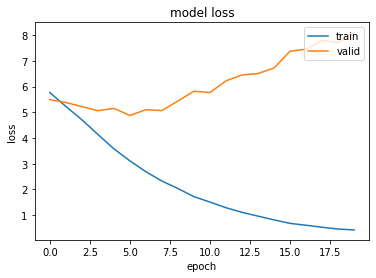

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.yscale('log')
# plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


With Progressive Loading

In [ ]:
# batch size = 2,4,8,16, 32,64, 128,256,512,1024,2048,4096,8192,16384 (2^n)
if PROGRESSIVE_LOADING == 1:
  # Define model
  model = define_model(vocabs_size, max_length)
  # Define fitting hyperparameters
  epochs = 20
  # batch_size_train = 100
  # batch_size_valid = 100
  num_images_per_batch_train = 7
  num_images_per_batch_valid = 7
  batch_size_train = math.ceil(len(captions_train)/num_images_per_batch_train)
  batch_size_valid = math.ceil(len(captions_valid)/num_images_per_batch_valid)
  # steps_per_epochs_train = num_images_per_batch_train
  # steps_per_epochs_valid = num_images_per_batch_valid
  print('Num. of training images  :',len(captions_train))
  print('Num. of validation images:',len(captions_valid))
  print('Num. of training images per batch  :',num_images_per_batch_train)
  print('Num. of validation images per batch:',num_images_per_batch_valid)
  print('Batch size train:',batch_size_train)
  print('Batch size valid:',batch_size_valid)
  print('Num. of epochs:', epochs)
  # print('steps_per_epochs_train:',steps_per_epochs_train)
  # print('steps_per_epochs_valid:',steps_per_epochs_valid)
  # Loop for fitting
  for i in range(1,epochs):
    print('Epoch #',i)
    # Create the data generator
    generator_train = data_generator(captions_train, images_features_train,
                                     tokenizer, num_uniqe_words,
                                     max_length, num_images_per_batch_train)
    
    generator_valid = data_generator(captions_valid, images_features_valid,
                                     tokenizer, num_uniqe_words,
                                     max_length, num_images_per_batch_valid)
    # Fit for one epoch
    model.fit(x=generator_train, epochs=1, verbose=1,
              steps_per_epoch=batch_size_train,
              validation_data=generator_valid,
              validation_steps=batch_size_valid,
              max_queue_size=1, workers=1,
              use_multiprocessing=False)
    
    # model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # Save model
    model.save('MODELS/model_BS'+ str(batch_size_train) + '_EP' + str(i) + '.h5')

**Finally, Model Evaluation**

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, image_features, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, images_features, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, images_features[key][0], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list[0]]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
from keras.models import load_model
# load the model
# filename = 'MODELS/model-batch_size16384-ep020-loss4.922-val_loss5.565.h5'
# model = load_model(filename)
evaluate_model(model, captions_valid, images_features_valid, tokenizer, max_length)

BLEU-1: 0.132812
BLEU-2: 0.033268
BLEU-3: 0.129783
BLEU-4: 0.182396


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
